In [1]:
import nibabel as nib
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
from einops.layers.torch import Rearrange
import torch
import torchvision

In [4]:
def normalize_frame(frame):
    """Normalize the frame data to 0-255."""
    frame = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX)
    return frame.astype(np.uint8)

def write_frames_to_video(frames, output_path, fps=30, frame_size=(320, 240)):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    
    # Create the VideoWriter object
    out = cv2.VideoWriter(output_path, fourcc, fps, frame_size)

    # Loop over each frame and write it to the video
    for frame in frames:
        # Normalize the frame to ensure it displays correctly
        frame = normalize_frame(frame)
        
        # Convert grayscale to BGR for video
        frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
        
        # Pad frame to maintain aspect ratio instead of resizing
        h, w = frame.shape[:2]
        aspect_ratio = frame_size[0] / frame_size[1]
        if w / h > aspect_ratio:  # Wide image
            new_w = frame_size[0]
            new_h = int(new_w * h / w)
        else:  # Tall image
            new_h = frame_size[1]
            new_w = int(new_h * w / h)
        
        # Resize while keeping aspect ratio
        resized_frame = cv2.resize(frame, (new_w, new_h))
        
        # Pad the image to match the target frame size
        delta_w = frame_size[0] - new_w
        delta_h = frame_size[1] - new_h
        top, bottom = delta_h // 2, delta_h - (delta_h // 2)
        left, right = delta_w // 2, delta_w - (delta_w // 2)
        padded_frame = cv2.copyMakeBorder(resized_frame, top, bottom, left, right, cv2.BORDER_CONSTANT)

        # Write the padded frame to the video
        out.write(padded_frame)
    
    # Release the VideoWriter
    out.release()
    print(f'Video saved to {output_path}')

In [6]:
path = r".\data\I304790_Resting_State_fMRI_20120515163828_501.nii"

# Load the image using nibabel
img = nib.load(path)
data = img.get_fdata()
print(data.shape)

# Define the number of rows and columns for the grid (adjust as needed)
time_stamps = data.shape[3]

num_cols = int(np.ceil(np.sqrt(time_stamps)))
num_rows = int(np.ceil(time_stamps / num_cols))

grid_img = np.zeros([768, 768])
offset = 0

for slice_index_z in range(data.shape[2]): # for temp_index in range(time_stamps):
    # Create a figure for the grid
    # fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))
    frames = []

    for temp_index in range(time_stamps):
        frame = data[:, :, slice_index_z, temp_index]
        frame = normalize_frame(frame)
        # frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)

        row = temp_index // num_cols
        col = temp_index % num_cols

        # Compute the position in the grid image
        row_start = row * 64
        row_end = row_start + 64
        col_start = col * 64
        col_end = col_start + 64

        # Place the frame in the appropriate position
        grid_img[row_start:row_end, col_start:col_end] = frame
        
        frames.append(frame)

    cv2.imwrite(f"movies/grid_img_{slice_index_z}.jpg", grid_img)


(64, 64, 48, 140)


torch.Size([1, 64, 64, 48, 140])
torch.Size([1, 48, 64, 64, 140])


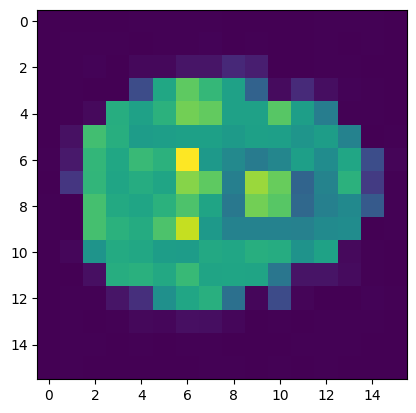

In [33]:
path = r".\data\I304790_Resting_State_fMRI_20120515163828_501.nii"

# Load the image using nibabel
img = nib.load(path)
data = img.get_fdata()
data = np.expand_dims(data, axis=0)
data = torch.tensor(data)
print(data.shape)

funct = Rearrange("b h w c t -> b c h w t")
data = funct(data)
print(data.shape)

for batch in data:
    brain_slice = batch[25]
    brain_slice_t = brain_slice[:, :, 10]
    
    brain_slice_t = brain_slice_t.numpy()
    brain_slice_t = cv2.resize(brain_slice_t, [16, 16])
    plt.imshow(brain_slice_t)